In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor,gradient_boosting,BaggingRegressor,ExtraTreesRegressor,GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


## Problem Description
Your goal is to predict the total_cases label for each (city, year, weekofyear) in the test set. There are two cities, San Juan and Iquitos, with test data for each city spanning 5 and 3 years respectively. You will make one submission that contains predictions for both cities. The data for each city have been concatenated along with a city column indicating the source: sj for San Juan and iq for Iquitos. The test set is a pure future hold-out, meaning the test data are sequential and non-overlapping with any of the training data. Throughout, missing values have been filled as NaNs.

For more Detail : https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/#features_list


### load the data Set

In [2]:
train=pd.read_csv("dataset/dengue_features_train.csv")
label=pd.read_csv("dataset/dengue_labels_train.csv")
test=pd.read_csv("dataset/dengue_features_test.csv")

In [3]:
train_df = train.copy()
label_df = label.copy()

In [4]:
print("train shape",train_df.shape)
print("label shape",label_df.shape)

train shape (1456, 24)
label shape (1456, 4)


In [5]:
df = pd.merge(train_df, label, how='left', on=['city','year', 'weekofyear'])
df.shape

(1456, 25)

In [6]:
df.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')

### Histogram of All Column

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EFCC115EF0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001EFCCB11B70>]], dtype=object)

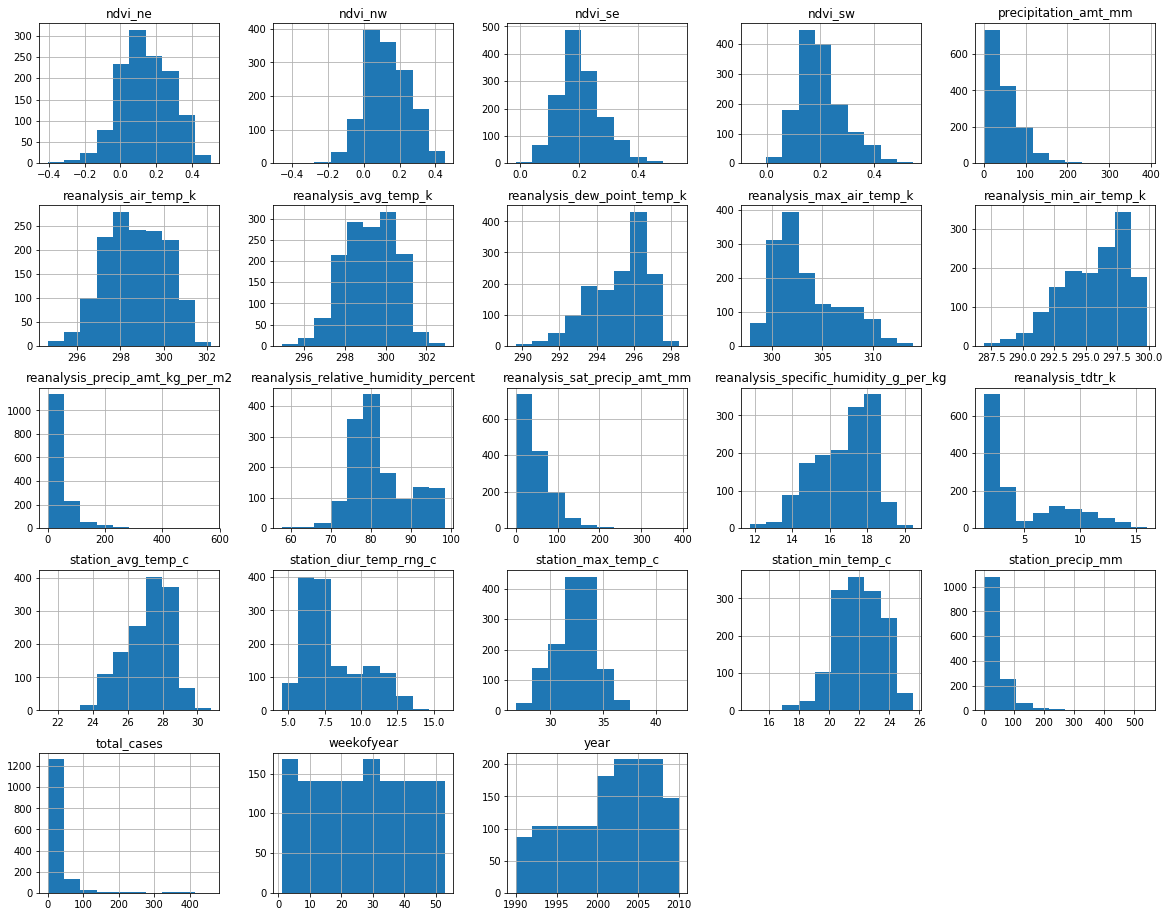

In [7]:
df.hist(figsize=(20,16))

### Remove Null value with mean

In [8]:
df = df.fillna(df.mean())

### Lable Encoding for categorical variable

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
lb=LabelEncoder()
df['city']=lb.fit_transform(df['city'])

In [11]:
df=df.drop(['week_start_date'],axis=1)

In [12]:
df.head(2)

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,1990,18,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1,1990,19,0.1699,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5


### Correlation Matrix for Feature Selection

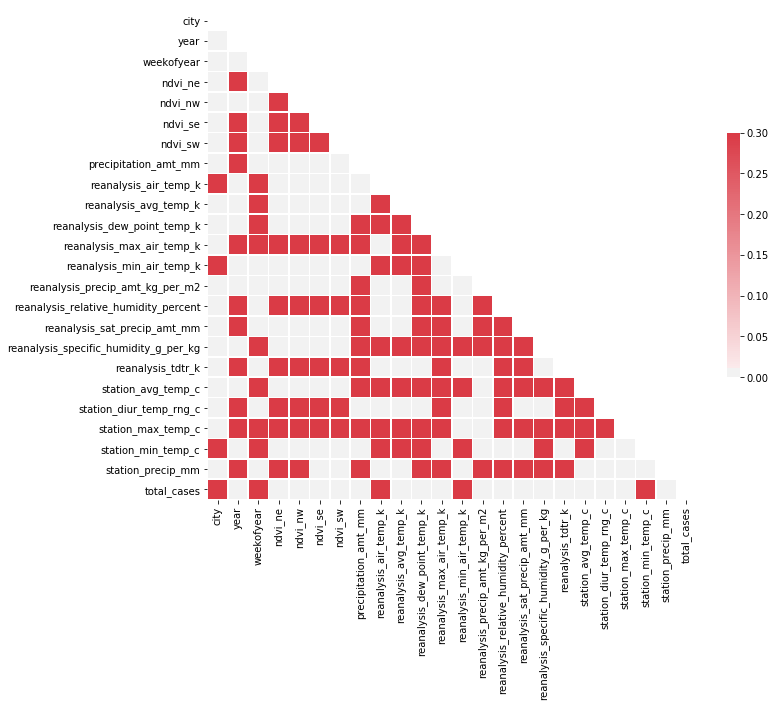

In [19]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr>0.20, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Split Train and Test Data 

In [13]:
# df = df.drop(['year',u'ndvi_ne',
#        u'ndvi_nw', u'ndvi_se', u'ndvi_sw', u'precipitation_amt_mm','reanalysis_max_air_temp_k',u'reanalysis_precip_amt_kg_per_m2',
#        u'reanalysis_relative_humidity_percent',
#        u'reanalysis_sat_precip_amt_mm', u'station_diur_temp_rng_c',
#        u'station_max_temp_c', u'station_precip_mm',],axis=1)
label = u'total_cases'
a = list(df.columns)
a.remove(label)
labels = df[label]
data_only = df[list(a)]
col_name = data_only.columns
data_only = preprocessing.scale(data_only)
X_train, X_test, y_train, y_test = train_test_split(data_only, labels, test_size=0.1,random_state = 42)


### Best Regression Model for this Dataset

In [14]:
 Rregression = [
        GradientBoostingRegressor(),
      ExtraTreesRegressor(max_features= 7),
     BaggingRegressor(),
     RandomForestRegressor(n_estimators=100,max_features=7,max_depth=5)
     
    ]

### Model load with mean and r2 accuracy

In [20]:

for classifier in Rregression:
    try:
       
        fit = classifier.fit(X_train,y_train)
        pred = fit.predict(X_test)
    except Exception:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        fit = classifier.fit(X_train,y_train)
        pred = fit.predict(X_test)
        
    print ("mean_error",classifier.__class__ ,mean_absolute_error(y_test, pred))
    print ("r squre",classifier.__class__ , r2_score(y_test, pred))
   

mean_error <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'> 15.3001094924
r squre <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'> 0.581706257685
mean_error <class 'sklearn.ensemble.forest.ExtraTreesRegressor'> 18.3698630137
r squre <class 'sklearn.ensemble.forest.ExtraTreesRegressor'> 0.40275915639
mean_error <class 'sklearn.ensemble.bagging.BaggingRegressor'> 15.0109589041
r squre <class 'sklearn.ensemble.bagging.BaggingRegressor'> 0.490855638581
mean_error <class 'sklearn.ensemble.forest.RandomForestRegressor'> 17.3598673766
r squre <class 'sklearn.ensemble.forest.RandomForestRegressor'> 0.412446403443


### Best Model load for predict value

In [17]:
clf = GradientBoostingRegressor()
fit = clf.fit(data_only,labels)


### Feature Important Insight of Model

In [18]:
imp = fit.feature_importances_
d = {'name': col_name,'value':imp}
d = pd.DataFrame(data =d)
d = d.set_index('name')


In [19]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

data = [go.Bar(
            x=imp,
            y=col_name,
            orientation = 'h'
)]
layout = go.Layout(
    hovermode= 'closest',
    autosize = True,)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### Test Data prediction

In [20]:
test['city']=lb.fit_transform(test['city'])
test=test.drop(['week_start_date'],axis=1)
test.shape


(416, 23)

In [21]:
test =test.fillna(test.mean())

In [22]:
test1 = preprocessing.scale(test)

In [23]:
predictions = fit.predict(test1)
p=predictions.astype('int')

### Prediction Value

In [24]:
p

array([ 29,  24,  24,  23,  27,  29,  39,  43,  25,  22,  16,  24,  29,
        34,  49,  79,  62,  78, 101,  81,  86,  76, 149, 105, 108, 100,
        90, 101, 126, 104,  97,  83,  81,  87,  70,  62,  56,  44,  54,
        52,  43,  45,  45,  43,  69,  34,  36,  38,  35,  39,  36,  38,
        38,  36,  37,  38,  51,  43,  37,  51,  77,  47,  64,  48,  72,
        66,  80,  76,  81, 138, 213, 197, 212, 245, 235, 245, 242, 222,
       249, 220, 222, 229, 238, 227, 202, 200, 141,  77,  65,  64,  57,
        65,  61,  60,  57,  52,  52,  47,  49,  52,  50,  49,  42,  45,
        46,  65,  49,  52,  50, 118,  86,  70,  45,  66,  78, 117,  70,
        57,  79,  93, 109, 121, 100, 117,  98,  94,  80,  86,  92, 107,
       106,  75,  61,  59,  68,  54,  73,  66,  62, -29,  13,  12,  13,
        13,  16,  12,  10,  10,   9,   8,   5,   4,   8,   1,   3,   4,
         4,   5,   4,   3,   6,   6,   7,  20,  30,   8,  13,  23,  20,
        41,  17,  36,  22,  24,  20,  19,  33,  15,  23,  27,  2

In [31]:
# test['total_cases']=p
# test['city']=lb.inverse_transform(test['city'])

In [32]:
# test[['city','year','weekofyear','total_cases']].to_csv("dataset/submission1.csv" ,index=False)